In [3]:
# Import the necessary libraries from PySpark
from pyspark.sql import SparkSession

# Create a SparkSession. This is the entry point to all Spark functionality.
# We give our application a name, "FlightPulse-ETL".
spark = SparkSession.builder.appName("FlightPulse-ETL").getOrCreate()

print("SparkSession created successfully!")

SparkSession created successfully!


In [4]:
# Define the path to your NEW dataset inside the Docker container
file_path = "flights.csv" # <-- We are now using the CSV file!

# Read the CSV file into a Spark DataFrame
df = spark.read.csv(file_path, header=True, inferSchema=True)

print("CSV dataset loaded successfully into Spark DataFrame.")

CSV dataset loaded successfully into Spark DataFrame.


In [5]:
# Print the schema to see the column names and their data types
print("DataFrame Schema:")
df.printSchema()

# Show the first 5 rows of the DataFrame to see what the data looks like
print("First 5 rows of the DataFrame:")
df.show(5)

DataFrame Schema:
root
 |-- FLIGHT_DATE: string (nullable = true)
 |-- FLIGHT_TIME: timestamp (nullable = true)
 |-- TIME_OF_DAY: string (nullable = true)
 |-- AIRLINE_CD: string (nullable = true)
 |-- FLIGHT_NO: string (nullable = true)
 |-- DEPARTURE_STATION_CD: string (nullable = true)
 |-- ARRIVAL_STATION_CD: string (nullable = true)
 |-- ARRIVAL_COUNTRY: string (nullable = true)
 |-- ARRIVAL_REGION: string (nullable = true)
 |-- HAUL: string (nullable = true)
 |-- AIRCRAFT_TYPE: string (nullable = true)
 |-- FIRST_CLASS_SEATS: integer (nullable = true)
 |-- BUSINESS_CLASS_SEATS: integer (nullable = true)
 |-- ECONOMY_SEATS: integer (nullable = true)
 |-- TIER1_ELIGIBLE_PAX: integer (nullable = true)
 |-- TIER2_ELIGIBLE_PAX: integer (nullable = true)
 |-- TIER3_ELIGIBLE_PAX: integer (nullable = true)

First 5 rows of the DataFrame:
+-----------+-------------------+-----------+----------+---------+--------------------+------------------+---------------+--------------+-----+---------

In [6]:
# Import necessary functions from PySpark for data manipulation
from pyspark.sql.functions import col, to_date, dayofweek, count, when, isnull

# --- 1. Check for Missing Values ---
# This command goes through each column and counts the number of null (empty) values.
print("Count of null values in each column:")
df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()


# --- 2. Correct Date Format & 3. Feature Engineering ---
# We create a new DataFrame called 'df_transformed'
df_transformed = df.withColumn(
    # Convert the 'FLIGHT_DATE' string column to a proper Date type
    "flight_date_formatted", 
    to_date(col("FLIGHT_DATE"), "dd-MM-yyyy")
).withColumn(
    # Create a new column 'DayOfWeek' (1=Sun, 2=Mon, ..., 7=Sat) from the new date column
    "day_of_week",
    dayofweek(col("flight_date_formatted"))
)

print("Transformed DataFrame with new date and day of week columns:")
# Show a few key columns from our new DataFrame to see the results
df_transformed.select("FLIGHT_DATE", "flight_date_formatted", "day_of_week", "DEPARTURE_STATION_CD", "ARRIVAL_STATION_CD").show(5)

Count of null values in each column:
+-----------+-----------+-----------+----------+---------+--------------------+------------------+---------------+--------------+----+-------------+-----------------+--------------------+-------------+------------------+------------------+------------------+
|FLIGHT_DATE|FLIGHT_TIME|TIME_OF_DAY|AIRLINE_CD|FLIGHT_NO|DEPARTURE_STATION_CD|ARRIVAL_STATION_CD|ARRIVAL_COUNTRY|ARRIVAL_REGION|HAUL|AIRCRAFT_TYPE|FIRST_CLASS_SEATS|BUSINESS_CLASS_SEATS|ECONOMY_SEATS|TIER1_ELIGIBLE_PAX|TIER2_ELIGIBLE_PAX|TIER3_ELIGIBLE_PAX|
+-----------+-----------+-----------+----------+---------+--------------------+------------------+---------------+--------------+----+-------------+-----------------+--------------------+-------------+------------------+------------------+------------------+
|          0|          0|          0|         0|        0|                   0|                 0|              0|             0|   0|            0|                0|                   0

In [7]:
# Import the functions we'll need for analysis
from pyspark.sql.functions import col, concat_ws, desc

# --- 1. Create a Temporary View ---
# To use SQL queries on our DataFrame, we need to register it as a temporary table or view.
# Let's call our table "flights".
df_transformed.createOrReplaceTempView("flights")


# --- 2. Write and Run the SQL Query ---
# This SQL query does a few things:
# - Creates a 'route' column by combining the departure and arrival stations (e.g., "LHR-LAX")
# - Groups by this new 'route' column and counts how many times each one appears
# - Orders the results in descending order to see the busiest routes at the top
# - Limits the result to the top 10
top_10_routes = spark.sql("""
    SELECT 
        route, 
        COUNT(*) AS flight_count
    FROM (
        SELECT 
            concat_ws('-', DEPARTURE_STATION_CD, ARRIVAL_STATION_CD) AS route 
        FROM flights
    )
    GROUP BY route
    ORDER BY flight_count DESC
    LIMIT 10
""")

print("Analysis Complete: Top 10 Busiest Routes")
# Show the results of our query
top_10_routes.show()

Analysis Complete: Top 10 Busiest Routes
+-------+------------+
|  route|flight_count|
+-------+------------+
|LHR-FRA|         714|
|LHR-MUC|         691|
|LHR-DXB|         688|
|LHR-VIE|         682|
|LHR-HND|         679|
|LHR-ORD|         675|
|LHR-MAD|         673|
|LHR-LAX|         666|
|LHR-JFK|         664|
|LHR-DFW|         653|
+-------+------------+



/tmp/ipykernel_512/2728645584.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="flight_count", y="route", data=top_10_routes_pandas, palette="viridis")


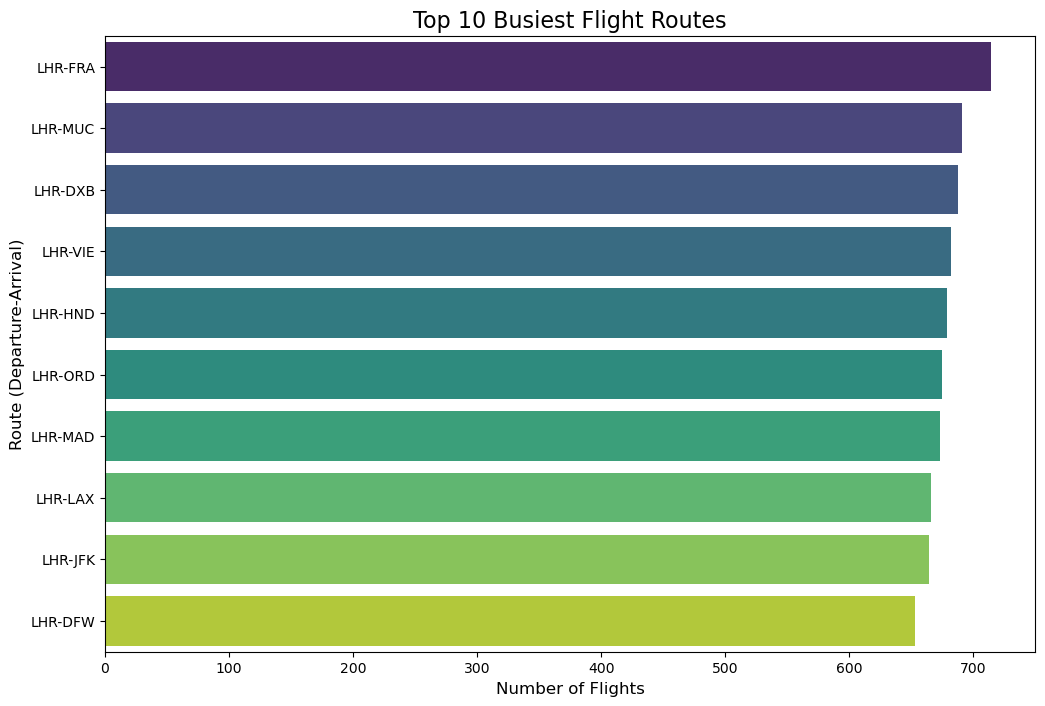

In [11]:
# Import the Python visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Convert Spark DataFrame to Pandas DataFrame ---
# Most Python plotting libraries, like Seaborn, work best with Pandas DataFrames.
# The .toPandas() method is an easy way to collect the results from our distributed Spark DataFrame 
# into a single Pandas DataFrame on the driver node.
top_10_routes_pandas = top_10_routes.toPandas()


# --- 2. Create the Bar Chart ---
# Set the size of our plot
plt.figure(figsize=(12, 8))

# Use the Seaborn library to create the bar plot
# We set the x-axis to our 'route' column and the y-axis to our 'flight_count' column
sns.barplot(x="flight_count", y="route", data=top_10_routes_pandas, palette="viridis")

# Add a title and labels for clarity
plt.title("Top 10 Busiest Flight Routes", fontsize=16)
plt.xlabel("Number of Flights", fontsize=12)
plt.ylabel("Route (Departure-Arrival)", fontsize=12)

# Show the plot
plt.show()

In [8]:
# We will use our 'df_transformed' DataFrame from the previous step

print("Starting export...")

# This command will save the DataFrame as a new CSV file.
# .coalesce(1) is a crucial step: it combines Spark's many small part-files into a single output file.
# .mode('overwrite') will replace the file if it already exists, which is useful for re-running.
df_transformed.coalesce(1).write.csv(
    'work/cleaned_flights.csv', 
    header=True, 
    mode='overwrite'
)

print("Export complete! Check your 'FlightPulse' project folder for a new folder named 'cleaned_flights.csv'.")

Starting export...
Export complete! Check your 'FlightPulse' project folder for a new folder named 'cleaned_flights.csv'.
